In [1]:
# # Get data from SOLR and save it to a file
# from urllib.request import urlopen
# import json
# connection = urlopen('https://shapenet.org/solr/models3d/select?q=datasets%3AShapeNetCore+AND+wnhypersynsets%3A02828884&rows=100000&fl=fullId%2Ccategory%2Cwnsynset%2Cwnlemmas%2Cup%2Cfront%2Cunit%2Caligned.dims&wt=json&indent=true')
# response = json.load(connection)
# print(response['response']['numFound'], "documents found.")
# print(response)
# Print the name of each document.

# for doc in response['response']['docs']:
#   print(doc)

# with open('data.json', 'w') as outfile:
#     json.dump(response, outfile)


In [2]:
from pyvista import examples
from src.model_loader import ModelLoader 
import numpy as np
import pyvista as pv
from math import dist
import numpy as np

DATA_ROOT = "data\\shapenet_samples"
IMAGE_RES = 256
WINDOWSIZE = 512

def outRayFinder(pts):
    if len(pts) == 0:
        return None, None
    # Find the first element in pts that is differnt from pts[0] and return that point onelin
    if len(pts) > 2:
        points = np.array(pts)
        idx = np.where(np.isclose(points, points[0])  != [True, True, True])[0][1]
        return pts[0], pts[idx]
    else:
        return pts[0], pts[1]
    
def createBaseMesh(mesh):#
    # Add a thin box below the mesh
    bounds = mesh.bounds
    rnge = (bounds[1] - bounds[0], bounds[5] - bounds[4], bounds[3] - bounds[2]) # x z y
    # print(rnge)

    expand = 10
    height = rnge[2] * 0.05
    center = np.array(mesh.center)
    center -= [0, mesh.center[2] + (bounds[3] + (height/3 )) , 0]

    width = rnge[0] * (1 + expand)
    length = rnge[1] * (1 + expand)
    base_mesh = pv.Cube(center, width, height, length)
    # base_mesh.rotate_x(-90, inplace=True)
    return base_mesh

data = ModelLoader(DATA_ROOT)


Loading Models: 100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


In [3]:
# Model Augmentation
rotation = 180
catagory = "cow_mesh"
id_ = 0

# Load Data Paths
tex_path = data.get_model_paths()[catagory][id_].get_texture(0)
if tex_path is not None:
    obj_texture = pv.read_texture(tex_path)
obj_mesh = pv.read(data.get_model_paths()[catagory][id_].get_obj_path())

# 
base_mesh = createBaseMesh(obj_mesh)
obj_mesh.rotate_vector(vector=(0, 1, 0), angle=rotation, inplace=True)

# Camera Setup
dist_limit = -1
camera = pv.Camera()
camera.position = (4.0, 1.0, 4.0)

near_range = 0.3
far_range = 10
camera.clipping_range = (near_range, far_range)

frustum = camera.view_frustum()
frustum = frustum.extract_points(0)
frustum = frustum.extract_points(1)
frustum = frustum.extract_points(2)
frustum = frustum.extract_points(3)

# Calculates the mesh intersection of obj_mesh
position = camera.GetViewPlaneNormal()
end = (camera.position[0]*dist_limit, camera.position[1]*dist_limit,camera.position[2]*dist_limit)
line = pv.Line(pointa=position, pointb=end, resolution= 1)
points1, ind1 = obj_mesh.ray_trace(position, end)

in1, out1 = outRayFinder(points1)
print("Red Thickness:", dist(in1, out1) if (not in1 is None) else 0, "PTS =", in1, out1)

Red Thickness: 0.754219037591356 PTS = [0.15385737 0.03846434 0.15385737] [-0.37131336 -0.09282834 -0.37131336]


In [4]:
# Given the corners of a squrare in 3d space, this function will return a grid of 3d points that are evenly spaced n x n x 1
def planeToGrid(frustum, n, center=None):
    # Find the center of the plane
    if center is not None:
        center = center
    else:
        center = frustum.center

    corners = frustum.points
    # Find the normal of the plane
    normal = np.cross(corners[1] - corners[0], corners[2] - corners[0])
    normal /= np.linalg.norm(normal)

    # Find the width and height of the plane
    width = dist(corners[0], corners[1])
    height = dist(corners[0], corners[3])

    # Create a grid of points that are evenly spaced
    grid = pv.Plane(center, normal, width, height, i_resolution=n-1, j_resolution=n-1)
    return grid, grid.ctp() # ctp = cell to point
    

_, start_ray_pts = planeToGrid(frustum, IMAGE_RES)
_, end_ray_pts = planeToGrid(frustum, IMAGE_RES, camera.position)


In [5]:
# depth_map = np.zeros((IMAGE_RES*IMAGE_RES))
thicc_map = np.zeros((IMAGE_RES*IMAGE_RES))
for i in range(len(start_ray_pts.points)):
    # Calculate ray intersection of each point in the grid
    points, _ = obj_mesh.ray_trace(start_ray_pts.points[i], end_ray_pts.points[i])
    in1, out1 = outRayFinder(points)
    thicc_map[i] = dist(in1, out1) if (not in1 is None) else 0

In [6]:
thicc_map.reshape(IMAGE_RES, IMAGE_RES)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
pv.global_theme.background = (135, 206, 235)
pv.global_theme.smooth_shading = True
pv.global_theme.anti_aliasing = 'fxaa'
pv.set_jupyter_backend('pythreejs')

screenshot = True

show_edges = False
show_pts = False
show_planes = False

# 


# Plotting/Screenshot Code
pl = pv.Plotter(window_size=[WINDOWSIZE, WINDOWSIZE]) 

# Adds Object Meshes
try:
    obj = pl.add_mesh(obj_mesh, show_edges=show_edges, texture=obj_texture)
except :
    print("Textures Not Working!")
    obj = pl.add_mesh(obj_mesh, show_edges=show_edges)
# _ = pl.add_mesh(line, color='red')
_ = pl.add_mesh(base_mesh,color='green')

if in1 is not None:
    intersect11 = pv.Plane(center = in1, direction = (1,0,0))
    intersect12 = pv.Plane(center = out1, direction = (1,0,0))

    if show_planes:
        _ = pl.add_mesh(intersect11, color='r', opacity=0.5)
        _ = pl.add_mesh(intersect12, color='r', opacity=0.5)

    if show_pts:
        _ = pl.add_points(in1, color='blue', point_size=50)
        _ = pl.add_points(out1, color='blue', point_size= 50)

pl.camera = camera
# 
# for i in range(len(start_ray_pts.points)):
#     _ = pl.add_mesh(pv.Line(pointa=start_ray_pts.points[i], pointb=end_ray_pts.points[i], resolution= 1), color='red')

# _ = pl.add_points(end_ray_pts, color='white', point_size=4)
# _ = pl.add_points(start_ray_pts, color='white', point_size=4)

if screenshot:
    # Screenshot code
    pl.ren_win.SetOffScreenRendering(5)
    img = pl.screenshot("result/moomoo.png",transparent_background=True, 
                        window_size=[IMAGE_RES,int(IMAGE_RES*pl.window_size[1]/pl.window_size[0])])
    depth_img = pl.get_image_depth(fill_value=np.nan)
else:
    pl.show_axes()
    pl.show()

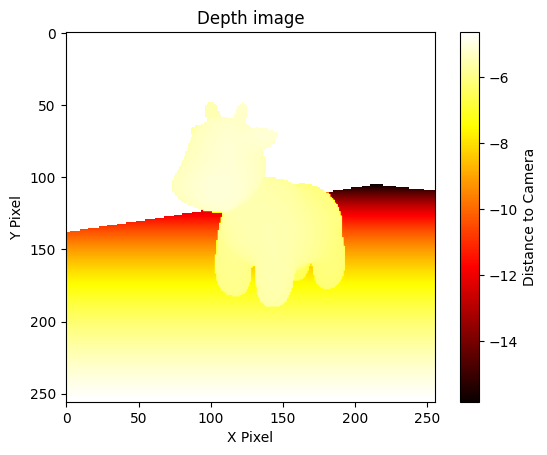

In [8]:
import matplotlib.pyplot as plt
photo = plt.imread("result/moomoo.png")

plt.figure()
plt.imshow(depth_img)
# plt.imshow(photo, alpha=0.5)

plt.colorbar(label='Distance to Camera')
plt.set_cmap('hot')
plt.title('Depth image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()

In [13]:
thicc_map = thicc_map.reshape(IMAGE_RES, IMAGE_RES)

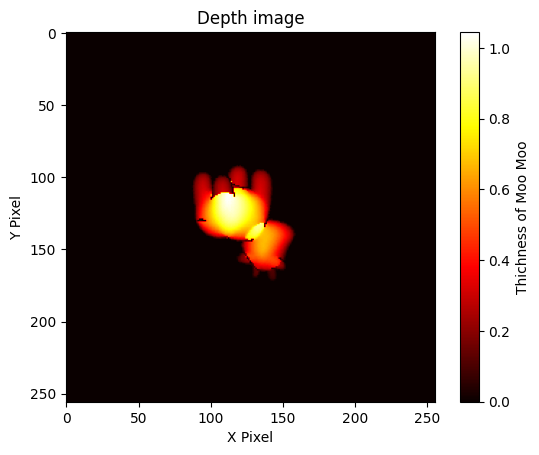

In [14]:
import matplotlib.pyplot as plt
photo = plt.imread("result/moomoo.png")

plt.figure()
plt.imshow(thicc_map)
# plt.imshow(photo, alpha=0.5)

plt.colorbar(label='Thichness of Moo Moo')
plt.set_cmap('hot')
plt.title('Depth image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()